# EDA

Flight Delay Prediction Challenge.
Predict airline delays for Tunisian aviation company, Tunisair.

Hypotheses:
1) Flights departing from certain airports experience longer delays than others.
2) Morning flights have fewer delays than evening flights.
3) Certain aircraft types have higher delays due to mainteance or operational issues.
4) Delays are higher during peak travel season?


## Load packages

In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor




## Load and explore data

Column definitions

DATOP - Date of flight <br>
FLTID - Flight number <br>
DEPSTN - Departure point <br>
ARRSTN - Arrival point <br>
STD - Scheduled Time departure <br>
STA - Scheduled Time arrival <br>
STATUS - Flight status <br>
AC - Aircraft Code <br>
Target - Delay in minutes <br>

In [2]:
df = pd.read_csv("data/RawData.csv")
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [3]:
print("shape", df.shape)
print(df.info())

shape (107833, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB
None


In [268]:
# Convert columns
df["DATOP"] = pd.to_datetime(df["DATOP"])
df["STD"] = pd.to_datetime(df["STD"])
df["STA"] = pd.to_datetime(df["STA"], format='%Y-%m-%d %H.%M.%S')

# Add columns
df["FlightYear"] = df["DATOP"].dt.year
df["Departure_Month"] = df["STD"].dt.month
df["Departure_Day"] = df["STD"].dt.day
df["Departure_Weekday"] = df["STD"].dt.weekday

df["Departure_Hour"] = df["STD"].dt.hour
df["Departure_Minute"] = df["STD"].dt.minute

# Classifying into morning (4-12), afternoon (12-17), evening (18-23) and night (0-4)
df['Departure_Time_Of_Day'] = pd.cut(df['Departure_Hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

# Calculating flight duration
df['Flight_Duration'] = (((df['STA'] - df['STD']).dt.total_seconds()) / 60).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94146 entries, 0 to 107831
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     94146 non-null  object        
 1   DATOP                  94146 non-null  datetime64[ns]
 2   FLTID                  94146 non-null  object        
 3   DEPSTN                 94146 non-null  object        
 4   ARRSTN                 94146 non-null  object        
 5   STD                    94146 non-null  datetime64[ns]
 6   STA                    94146 non-null  datetime64[ns]
 7   AC                     94146 non-null  object        
 8   target                 94146 non-null  float64       
 9   FlightYear             94146 non-null  int32         
 10  Departure_Month        94146 non-null  int32         
 11  Departure_Day          94146 non-null  int32         
 12  Departure_Weekday      94146 non-null  int32         
 13  Depar

In [6]:
# Drop rows where STATUS is "RTR" (returned to origin), "DEL" (cancelled) or "SCH"(still in the air), because aircraft never arrived at destination
df = df[~df["STATUS"].isin(["RTR", "DEL", "SCH"])]
df["STATUS"].unique()

# Drop column "STATUS" because it is not informative
df =df.drop(columns=["STATUS"])

In [7]:
# Check missing values --> no missing values
print(df.isnull().sum())

ID                          0
DATOP                       0
FLTID                       0
DEPSTN                      0
ARRSTN                      0
STD                         0
STA                         0
AC                          0
target                      0
FlightYear                  0
Departure_Month             0
Departure_Day               0
Departure_Weekday           0
Departure_Hour              0
Departure_Minute            0
Departure_Time_Of_Day    1886
dtype: int64


In [8]:
# Checking for duplicates

def check_duplicates(data):
    has_dup = data.duplicated()
    true_dup = np.where(has_dup == True)
    if len(true_dup[0]) > 0:
        print("Data has", len(true_dup[0]), "duplicates")
    else:
        print("No duplicates found")

check_duplicates(df)

No duplicates found


<Axes: >

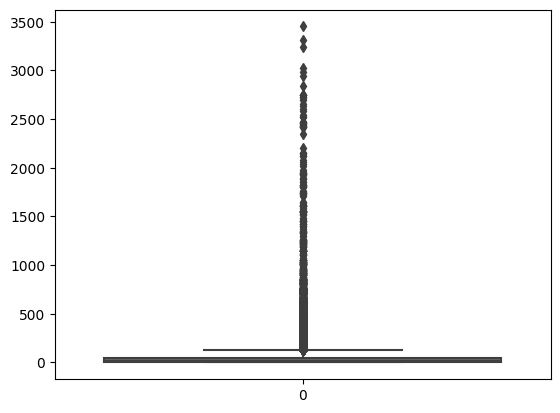

In [9]:
# Boxplot of target variable
sns.boxplot(df["target"])

In [10]:
# Columns of interest
interest = df.columns.drop(["ID", "DATOP", "STD", "STA"])

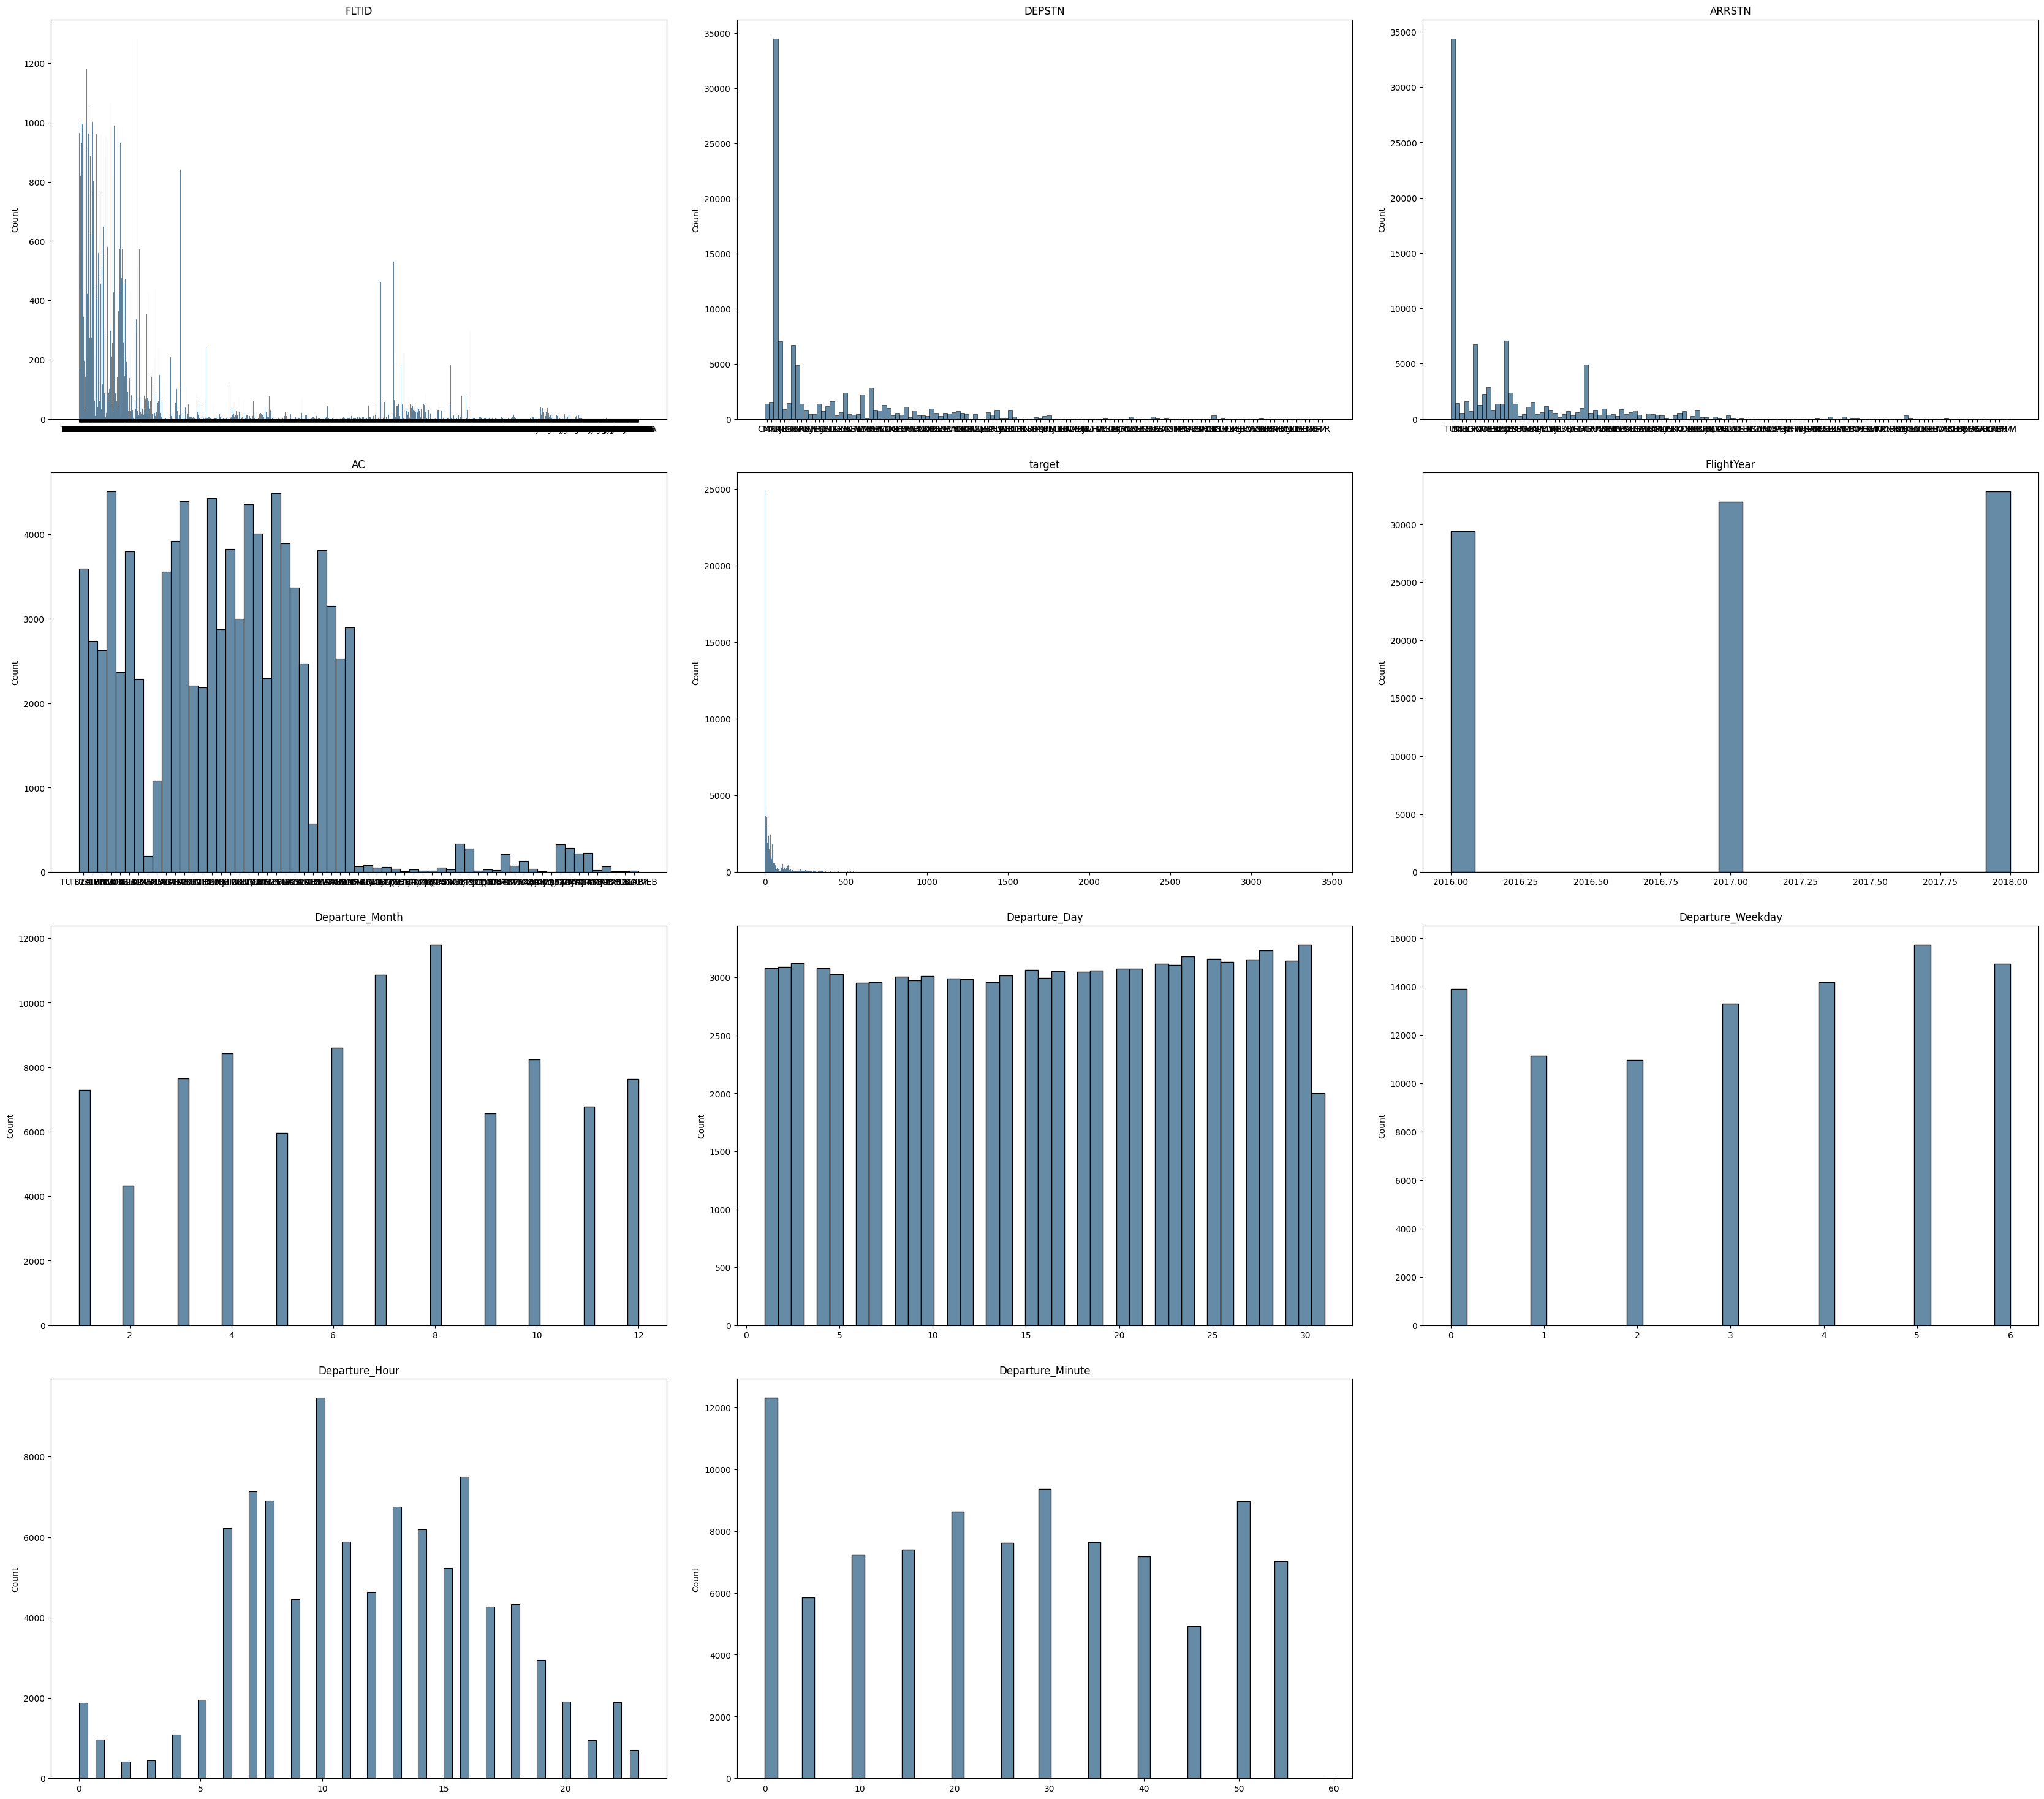

In [11]:
# Plot distribution of features 

fig,ax = plt.subplots(4,3,figsize=(34,30))
count = 0
for item in interest:
    sns.histplot(df[item], ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

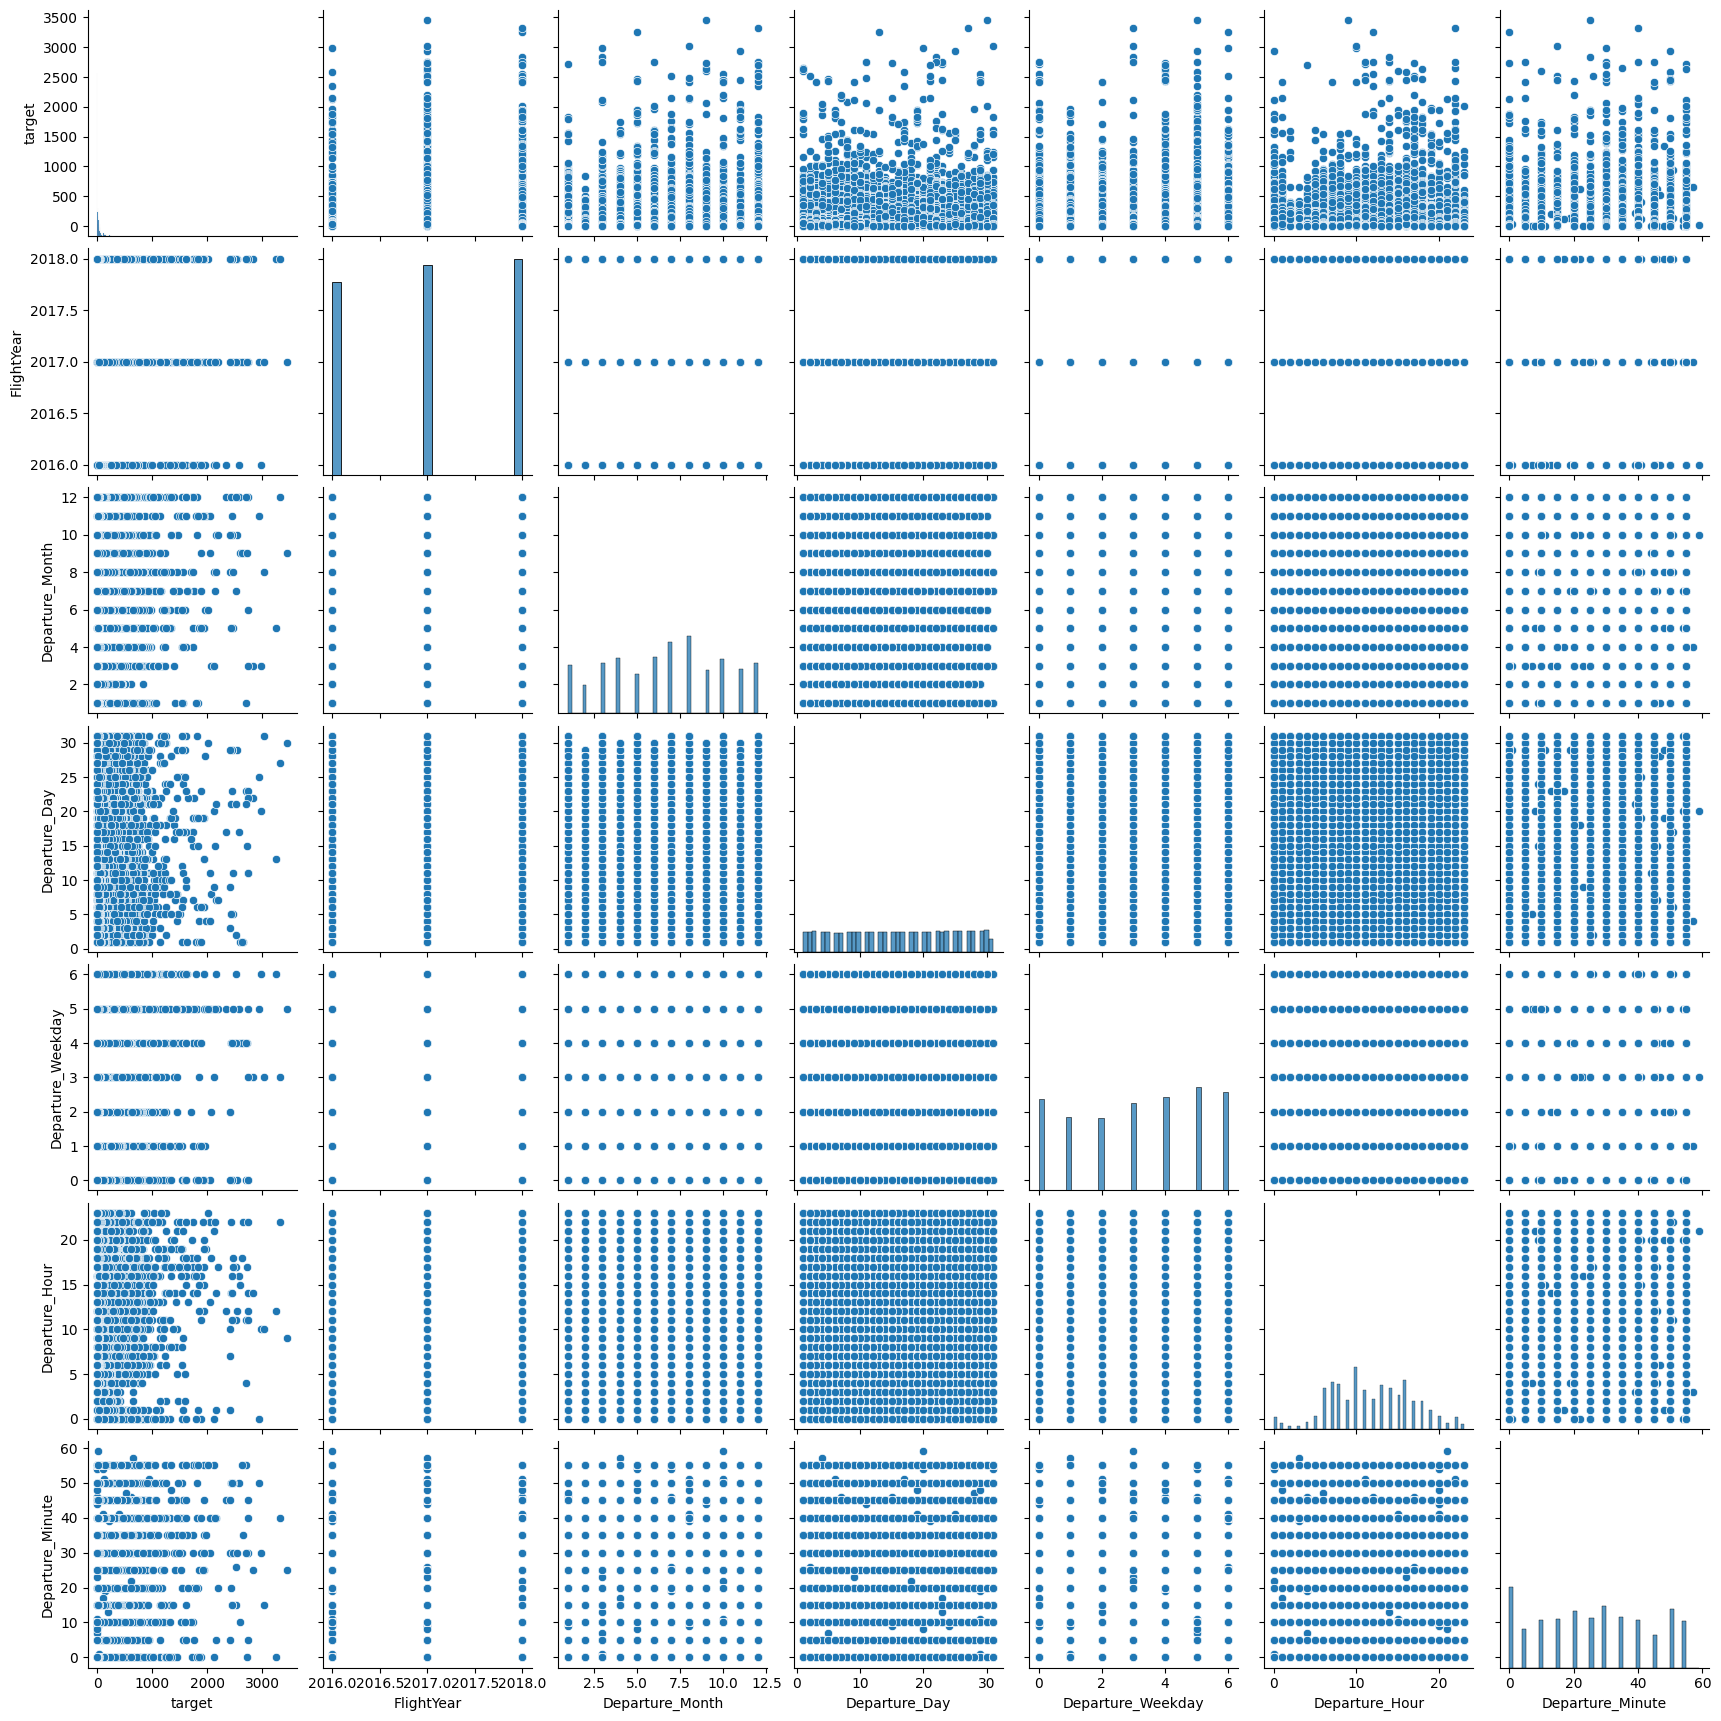

In [12]:
# Pairplot for columns of interest
sns.pairplot(df[interest])
plt.show()

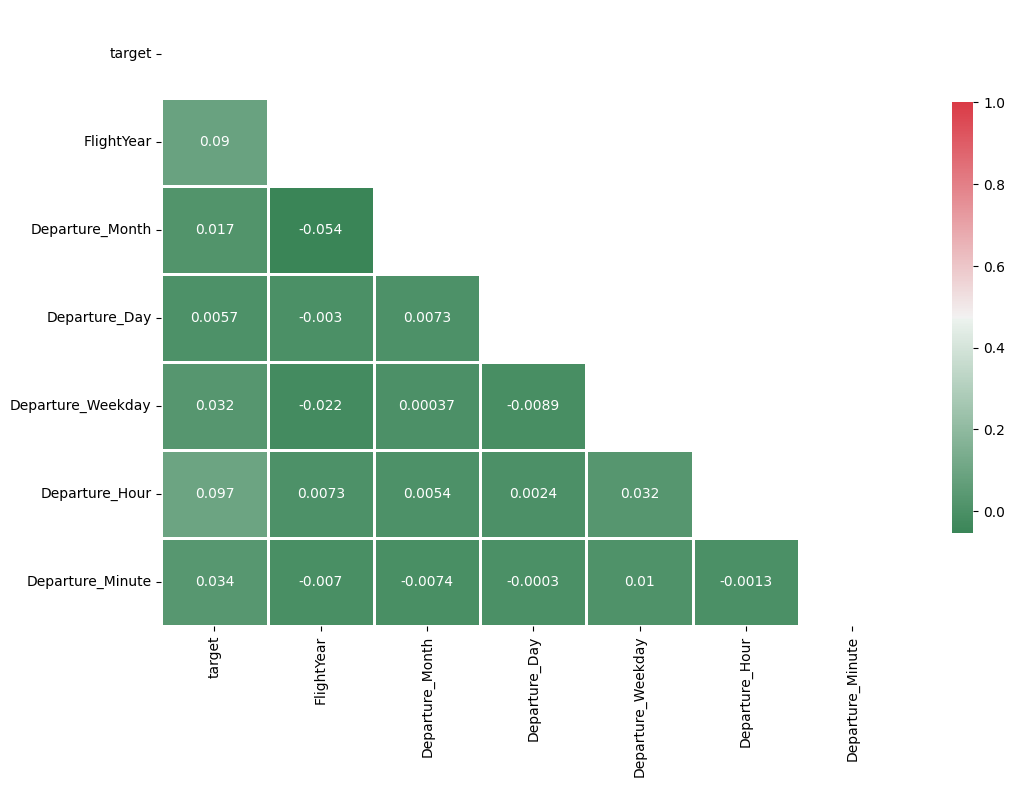

In [22]:
# Correlation heatmap

fig, ax = plt.subplots(figsize=(12,8))

# Create a new DataFrame that only includes the numerical variables
df_numeric = df[interest].select_dtypes(include=['float64', 'int32'])

# Compute correlations
correlations = df_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(140, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, annot=True,
            linewidths=1, cbar_kws={"shrink": .7}, ax=ax);

IndexError: index 5 is out of bounds for axis 0 with size 5

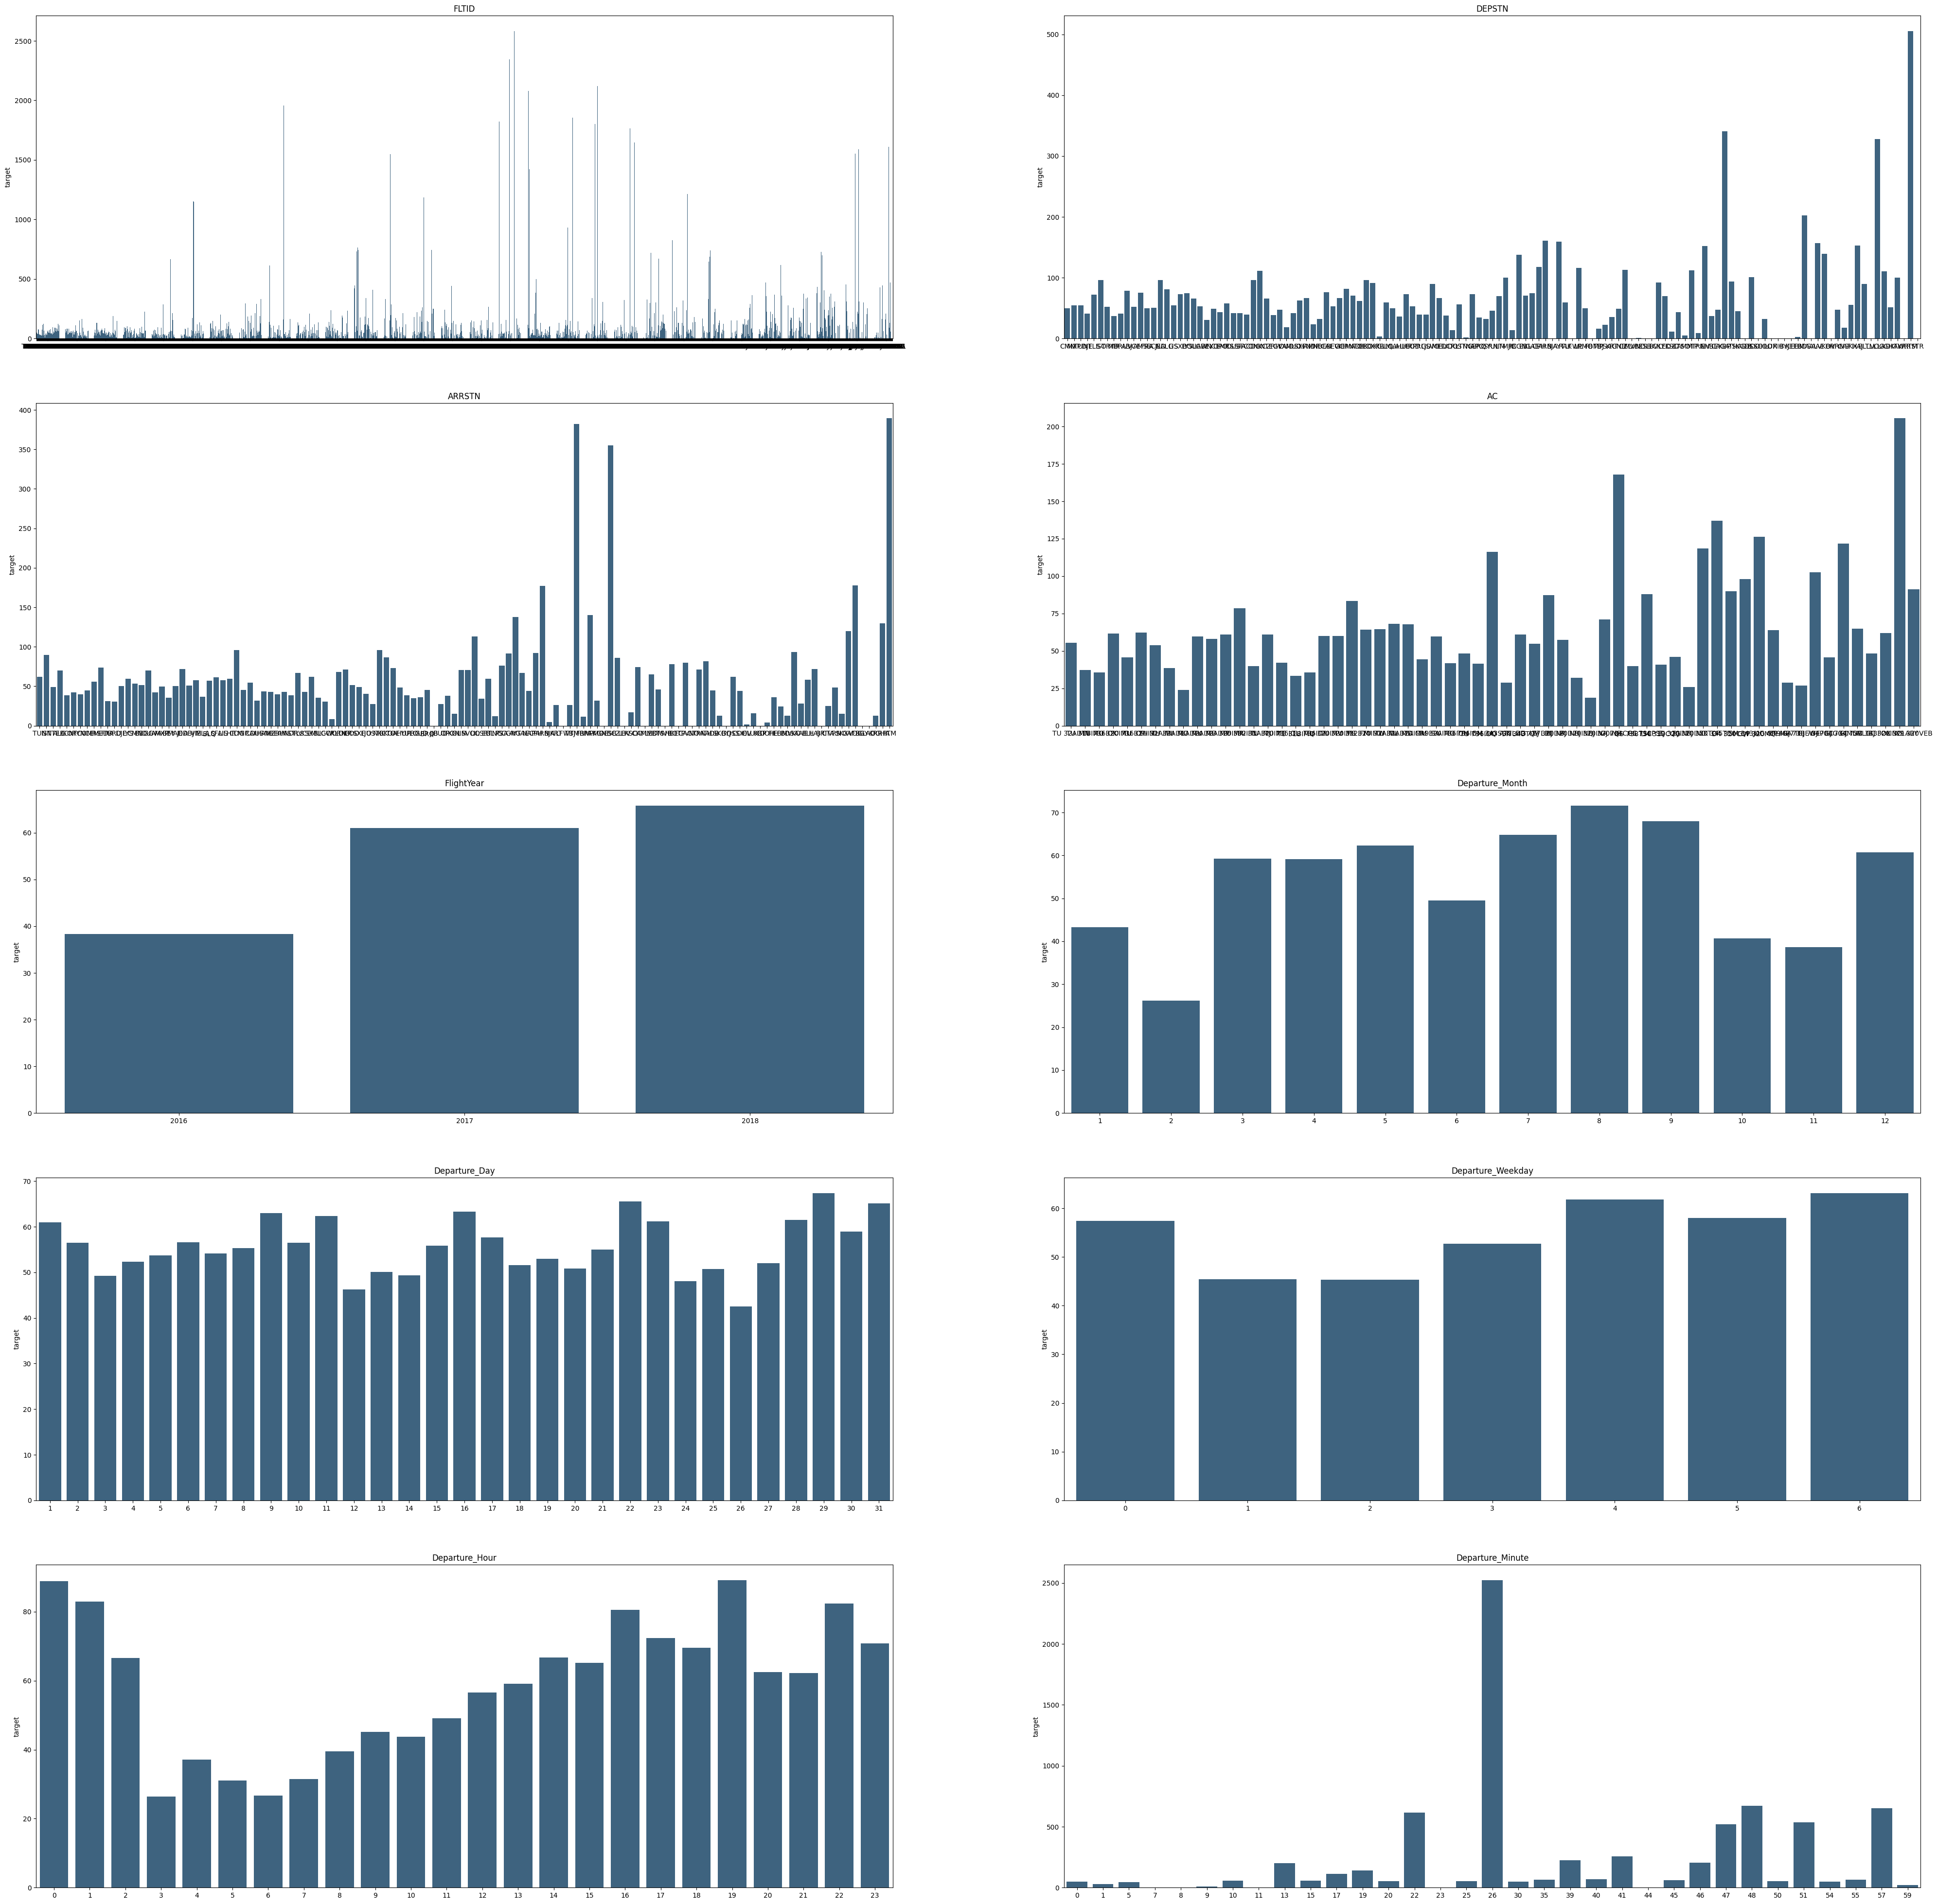

In [13]:
# Barplots
interest_withoutTarget = interest.drop("target")

fig,ax = plt.subplots(5,2,figsize=(50,50))
count = 0
for item in interest_withoutTarget:
    sns.barplot(df, x=df[item], y= df["target"], errorbar=None, ax=ax[int(count/2)][count%2], color='#33658A').set(title=item, xlabel='')
    count += 1
fig.tight_layout(pad=3)

In [14]:
# Check wether flights with high delay only flew once --> yes
# Flights get mean and count of flights
flights = df[["DEPSTN", "ARRSTN", "target"]]
flights = flights.groupby(["DEPSTN", "ARRSTN"]).agg(["mean", "count"]).sort_values(by=("target", "mean"), ascending=False)
flights 

target      
                 mean count
DEPSTN ARRSTN              
LYS    CDG     2456.0     1
TUN    SVO     2123.0     1
ORY    MRS      770.0     1
CAI    DJE      703.0     1
ATH    SFA      653.0     1
...               ...   ...
NCE    TOE        0.0     1
TUN    AMM        0.0     2
DJE    LIL        0.0     1
       IEV        0.0     3
SFA    LYS        0.0     1

[682 rows x 2 columns]

# Train-test split

In [269]:
# Train Test Split
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Feature Engineering

In [270]:
# Using OneHotEncoder to encode the categorical variables

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Fit and Transform
encoded_X_train = encoder.fit_transform(X_train[['DEPSTN', 'ARRSTN', 'Departure_Month', 'Departure_Weekday', 'Departure_Time_Of_Day']])
encoded_X_test = encoder.transform(X_test[['DEPSTN', 'ARRSTN', 'Departure_Month', 'Departure_Weekday', 'Departure_Time_Of_Day']])


# Convert to DataFrame
encoded_X_train = pd.DataFrame(encoded_X_train, columns=encoder.get_feature_names_out())
encoded_X_test = pd.DataFrame(encoded_X_test, columns=encoder.get_feature_names_out())

# Giving back index to dataframes. This is required because OneHotEncoder returns an arrage, which removes the index
encoded_X_train.index = X_train.index
encoded_X_test.index = X_test.index

# Now add back the flight duration column
encoded_X_train['Flight_Duration']  = X_train['Flight_Duration']
encoded_X_test['Flight_Duration']  = X_test['Flight_Duration']

/Users/aylinhanne/Documents/neuefische/ML_project/AirorPrediction/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [271]:
X_train = encoded_X_train
X_test = encoded_X_test

# Functions to evaluate model

In [239]:
def model_evaluation(train, train_pred, test, test_pred):

    print('Training evaluation metrics: ')
    print('Mean absolute error (MAE): ', mean_absolute_error(train, train_pred))
    print('Mean square error (MSE): ', mean_squared_error(train, train_pred))
    print('Root mean square error (RMSE): ', mean_squared_error(train, train_pred) **0.5)
    print('R2 coefficient of determination: ', r2_score(train, train_pred))
    print('')
    print('---'*5)
    print('Test Evaluation Metrics')
    print('Mean absolute error (MAE): ', mean_absolute_error(test, test_pred))
    print('Mean square error (MSE): ', mean_squared_error(test, test_pred))
    print('Root mean square error (RMSE):', mean_squared_error(test, test_pred) **0.5)
    print('R2 coefficient of determination: ', r2_score(test, test_pred))

# Define baseline model

In [257]:
# Dummy regressor; predicting mean

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
train_pred_dummy = dummy_regr.predict(X_train)
test_pred_dummy = dummy_regr.predict(X_test)

# Evaluate model
model_evaluation(y_train, train_pred_dummy, y_test, test_pred_dummy)


Training evaluation metrics: 
Mean absolute error (MAE):  62.70235914322194
Mean square error (MSE):  15357.759313578032
Root mean square error (RMSE):  123.92642701852593
R2 coefficient of determination:  0.0

---------------
Test Evaluation Metrics
Mean absolute error (MAE):  62.69099818234593
Mean square error (MSE):  14646.298949922631
Root mean square error (RMSE): 121.02189450641826
R2 coefficient of determination:  -1.7188068857088012e-07


# Implement models

In [258]:
# Linear regression model: Simon
lm = LinearRegression()

# Fit model to training data
lm.fit(X_train, y_train)

# Make predictions on train set
y_train_lm_pred = lm.predict(X_train)

# Make predictions on test set
y_test_lm_pred = lm.predict(X_test)

In [259]:
#Model evaluation
model_evaluation(y_train, y_train_lm_pred, y_test, y_test_lm_pred) 

Training evaluation metrics: 
Mean absolute error (MAE):  58.85456032785425
Mean square error (MSE):  14601.616164980913
Root mean square error (RMSE):  120.83714728915488
R2 coefficient of determination:  0.049235251911299405

---------------
Test Evaluation Metrics
Mean absolute error (MAE):  58.70503313883464
Mean square error (MSE):  13948.96931250663
Root mean square error (RMSE): 118.10575478149501
R2 coefficient of determination:  0.04761115707400154


In [ ]:
# Random forest with CV (categorical variables need first to be encoded)
RSEED = 99

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

random_grid = {'n_estimators': [int (x) for x in np.linspace(100, 200, num=10)], # The number of trees in the forest
               'max_depth':  [int (x) for x in np.linspace(1, 20, num=10)], #The maximum depth of the tree
               'min_samples_split': [3, 6], # The minimum number of samples required to split an internal node
               'min_samples_leaf': [1, 2, 3], #The minimum number of samples required to be at a leaf node
               'max_features': ['log2', 'sqrt'], #The number of features to consider when looking for the best split
               }

model_RF = RandomizedSearchCV(RandomForestRegressor(), param_distributions = random_grid, n_iter = 100, cv = cv, verbose=3, random_state=RSEED, n_jobs = -1)


# Fit on training data
model_RF.fit(X_train, y_train)

Fitting 9 folds for each of 100 candidates, totalling 900 fits


/Users/aylinhanne/Documents/neuefische/ML_project/AirorPrediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/aylinhanne/Documents/neuefische/ML_project/AirorPrediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/aylinhanne/Documents/neuefische/ML_project/AirorPrediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 5/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.033 total time=   6.8s
[CV 3/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.028 total time=   7.4s
[CV 4/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.034 total time=   7.5s
[CV 7/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.030 total time=   7.5s
[CV 2/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.033 total time=   7.6s
[CV 1/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.031 total time=   8.0s
[CV 6/9] END max_depth=17, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=166;, score=0.029 total time=   7.8s
[CV 8/9] END max_depth=17, max_features=l

In [266]:
# Print best parameters
print("Tuned hyperparameters :(best parameters) ",model_RF.best_params_)

Tuned hyperparameters :(best parameters)  {'n_estimators': 177, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [ ]:
# Feature importance
forest_importances = model_RF.feature_importances_

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [267]:
# Model evaluation 
y_train_RF_pred = model_RF.predict(X_train)
y_test_RF_pred = model_RF.predict(X_test)

#Model evaluation
model_evaluation(y_train, y_train_RF_pred, y_test, y_test_RF_pred) 

Training evaluation metrics: 
Mean absolute error (MAE):  60.103123541004365
Mean square error (MSE):  14623.854268758927
Root mean square error (RMSE):  120.92912911601955
R2 coefficient of determination:  0.04778724746455998

---------------
Test Evaluation Metrics
Mean absolute error (MAE):  60.36479264133259
Mean square error (MSE):  14173.254038198836
Root mean square error (RMSE): 119.05147642175143
R2 coefficient of determination:  0.03229774820468423


In [ ]:
# Boosting model

# Error plots

In [ ]:
def error_analysis_train(y_train, y_pred_train):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals_train = y_train - y_pred_train
    # Standardize residuals
    residuals_stand_train = (residuals_train - residuals_train.mean()) / residuals_train.std()
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Train data: Error Analysis')

    # Train data
    min_val_train = min(y_train.min(), y_pred_train.min())
    max_val_train  = max(y_train.max(), y_pred_train.max())
    
    ax[0].scatter(y_pred_train, y_train, color="#FF5A36", alpha=0.7)
    ax[0].plot([min_val_train , max_val_train], [min_val_train, max_val_train], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_train.min()-10), (y_pred_train.max()+10))
    ax[0].set_ylim((y_train.min()-40), (y_train.max()+40))
    
    ax[1].scatter(y_pred_train, residuals_train, color="#FF5A36", alpha=0.7)
    ax[1].plot([min_val_train, max_val_train], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_train.min()-10), (y_pred_train.max()+10))
    ax[1].set_ylim((residuals_train.min()-10), (residuals_train.max()+10));

    ax[2].scatter(y_pred_train, residuals_stand_train, color="#FF5A36", alpha=0.7)
    ax[2].plot([min_val_train , max_val_train], [0,0], color="#193251")
    ax[2].set_title("Standardized Residual Scatter Plot", fontsize=16)
    ax[2].set_xlabel("predicted values")
    ax[2].set_ylabel("standardized residuals")
    ax[2].set_xlim((y_pred_train.min()-10), (y_pred_train.max()+10))
    ax[2].set_ylim((residuals_stand_train.min()-10), (residuals_stand_train.max()+10));


In [ ]:
def error_analysis_test(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    # Standardize residuals
    residuals_stand = (residuals - residuals.mean()) / residuals.std()
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Test data: Error Analysis')

    # Test data
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([min_val, max_val], [min_val, max_val], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([min_val, max_val], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

    ax[2].scatter(y_pred_test, residuals_stand, color="#FF5A36", alpha=0.7)
    ax[2].plot([min_val, max_val], [0,0], color="#193251")
    ax[2].set_title("Standardized Residual Scatter Plot", fontsize=16)
    ax[2].set_xlabel("predicted values")
    ax[2].set_ylabel("standardized residuals")
    ax[2].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[2].set_ylim((residuals_stand.min()-10), (residuals_stand.max()+10));

In [ ]:
error_analysis_train(y_train, y_pred_train)
error_analysis_test(y_test, y_pred_test)

# Feature plots

In [ ]:
# Partial dependence plots
## Information: https://www.blog.trainindata.com/partial-dependence-plots-with-python/
### These plots allow us to visualize the relationship between a specific feature and the model’s predictions while holding all other features constant.
### In a partial dependence plot, we can see how the value of the model’s output changes at different values of the predictor. Hence, we can understand how important the feature is, and also, whether the relationship is linear, monotonic, or something else, and the direction of influence of the feature on the prediction.

features = [0, 1, 2, 3, 4] # Features we want to plot
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(lin_reg, X_train, features=features, kind='average', subsample=50, ax=ax)
ax.set_title('Partial Dependence Plot')
plt.show()

In [ ]:
# Permutation feature importance
## Scoring method depends on the type of model (e.g. R^2 for regression models)
## Information: https://christophm.github.io/interpretable-ml-book/feature-importance.html
### We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 


perm_importance = permutation_importance(lin_reg, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort() #argsort sorts an array in ascending order and returns the indices of the sorted elements

plt.figure(figsize=(10, 6))
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.title("Permutation Importance")
plt.show()

